In [1]:
!sudo apt-get update >& /dev/null
!apt-get install -y xvfb x11-utils >& /dev/null
!pip install gym==0.17.* pyvirtualdisplay==0.2.* PyOpenGL==3.1.* PyOpenGL-accelerate==3.1.* >& /dev/null

In [2]:
!rm -rf ./video;
!mkdir -p ./video

In [3]:
import glob
import io
import base64
from IPython.display import HTML
from IPython import display as ipythondisplay

from pyvirtualdisplay import Display

display = Display(visible=0, size=(1368, 768))
display.start()

<Display cmd_param=['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '1368x768x24', ':1005'] cmd=['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '1368x768x24', ':1005'] oserror=None return_code=None stdout="None" stderr="None" timeout_happened=False>

In [4]:
def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay loop controls style="height: 256px;"> <source src="data:video/mp4;base64,{0}" type="video/mp4" /></video>'''.format(encoded.decode('ascii'))))
  else:
    print("Could not find video")

In [5]:
import gym
from gym.wrappers import Monitor

def wrap_env(env):
  ''''
  This monitoring wrapper records the outputs and save them in an mp4 file
  '''
  env = Monitor(env, './video', force=True)
  return env

## Let's play with FrozenLake

In [6]:
import gym.envs.toy_text.frozen_lake as fl

env = wrap_env(gym.make('FrozenLake8x8-v0'))
# env = wrap_env(gym.make('FrozenLake-v0'))

In [7]:
print('Action space for Frozen Lake env: '+ str(env.action_space))
print('Observation space for Frozen lake env: '+ str(env.observation_space))

Action space for Frozen Lake env: Discrete(4)
Observation space for Frozen lake env: Discrete(64)


In [8]:
actions = {fl.LEFT: '\u2190', fl.DOWN: '\u2193', fl.RIGHT: '\u2192', fl.UP: '\u2191'}

$Bellman\ Equations$


$V: S \rightarrow \mathbb{R}$

\begin{align*}
V^{\pi}(s) &= r(s, \pi(s)) + \gamma \mathbb{E}_{s'\sim p(s'|s, \pi(s))} \Big[V^{\pi}\left(s'\right) \Big]\\
 &=r(s, \pi(s)) + \gamma \sum\limits_{s'\in S} p\left(s'|s,\pi(s)\right) V^{\pi}(s')
\end{align*}


$Q: S \times A \rightarrow \mathbb{R}$

\begin{align*}
Q^{\pi}(s,a) &= r(s, a) + \gamma \mathbb{E}_{s'\sim p(s'|s, a)} \Big[ Q^{\pi}\left(s', \pi(s')\right)\Big]\\
 &=r(s, a) + \gamma \sum\limits_{s'\in S}p\left(s'|s,a\right) Q^{\pi}\left(s', \pi(s')\right)
\end{align*}

In [9]:
from tqdm import tqdm
import numpy as np

# Let's define a policy that always moves RIGHT
pi = fl.RIGHT*np.ones((env.observation_space.n), np.uint8)

gamma = 0.9
max_iterations = 40

def compute_Q_sequence(env, pi, gamma=0.9, max_iterations = 20):
  """
  Compute the value for each state
  """
  
  Q = np.zeros((env.observation_space.n, env.action_space.n))
  Qpi_sequence = [Q]

  for i in tqdm(range(max_iterations)):
    Qnew = np.zeros((env.observation_space.n, env.action_space.n))
    # recompute the values for each states in the value table
    for x in range(env.observation_space.n):
      for a in range(env.action_space.n):
        outcomes = env.unwrapped.P[x][a]
        for o in outcomes:
          p = o[0]
          y = o[1]
          r = o[2]
          Qnew[x][a] += p * (r + gamma*Q[y][pi[y]])
    Q = Qnew
    Qpi_sequence.append(Qnew)

  return Qpi_sequence

In [10]:
Qpi_sequence = compute_Q_sequence(env, pi=pi, gamma=gamma, max_iterations=max_iterations)

100%|██████████| 40/40 [00:00<00:00, 716.30it/s]


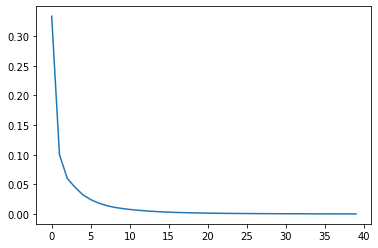

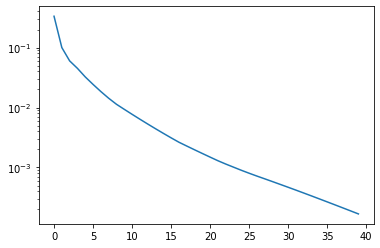

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

residuals = []
for i in range(1, len(Qpi_sequence)):
  residuals.append(np.max(np.abs(Qpi_sequence[i] - Qpi_sequence[i-1])))

plt.plot(residuals)
plt.figure()
plt.semilogy(residuals)

$Bellman\ Optimality\ Equations$


$V^*: S \rightarrow \mathbb{R}$

\begin{align*}
V^*(s) &= \max\limits_{a\in A}\left( r(s, a) + \gamma \mathbb{E}_{s'\sim p(s'|s, \pi(s))} \Big[V^*\left(s'\right) \Big]\right)\\
 &=\max\limits_{a\in A} \left(r(s, a) + \gamma \sum\limits_{s'\in S} p\left(s'|s,a\right) V^*(s')\right)
\end{align*}


$Q^*: S \times A \rightarrow \mathbb{R}$

\begin{align*}
Q^*(s,a) &= r(s, a) + \gamma \mathbb{E}_{s'\sim p(s'|s, a)} \Big[ \max\limits_{a'\in A}Q^*\left(s', a'\right)\Big]\\
 &=r(s, a) + \gamma \sum\limits_{s'\in S}p\left(s'|s,a\right) \max\limits_{a'\in A}Q^*\left(s', a'\right)
\end{align*}

In [12]:
# Value Iteration

def compute_Qopt_sequence(env, gamma=0.9, max_iterations = 20):
  """
  Compute the value for each state
  """
  
  Q = np.zeros((env.observation_space.n, env.action_space.n))
  Qopt_sequence = [Q]

  for i in tqdm(range(max_iterations)):
    Qnew = np.zeros((env.observation_space.n, env.action_space.n))
    # recompute the values for each states in the value table
    for x in range(env.observation_space.n):
      for a in range(env.action_space.n):
        outcomes = env.unwrapped.P[x][a]
        for o in outcomes:
          p = o[0]
          y = o[1]
          r = o[2]
          Qnew[x, a] += p * (r + gamma * np.max(Q[y, :]))
    Q = Qnew
    Qopt_sequence.append(Qnew)

  return Qopt_sequence

In [13]:
Qopt_sequence = compute_Qopt_sequence(env, gamma=gamma, max_iterations=max_iterations)

100%|██████████| 40/40 [00:00<00:00, 155.87it/s]


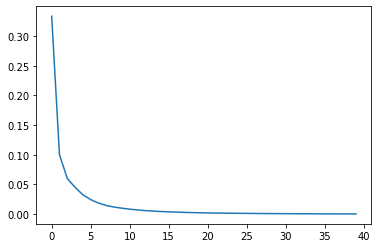

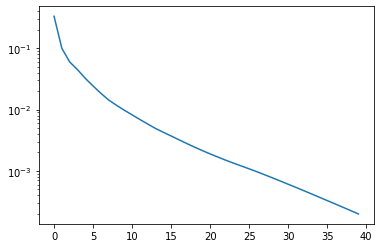

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline

residuals = []
for i in range(1, len(Qopt_sequence)):
  residuals.append(np.max(np.abs(Qopt_sequence[i] - Qopt_sequence[i-1])))

plt.plot(residuals)
plt.figure()
plt.semilogy(residuals)

Complexity of Value Iteration algorithm: $O(S^2A)$

# TD(0) temporal difference update on $Q$-functions

For a sample $(s,a,r,s')$, the temporal difference is:

$\delta = r + \gamma Q(s',\pi(s')) - Q(s,a)$

And the TD update is:

$Q(s,a) \leftarrow Q(s,a) + \alpha \left[ r + \gamma Q(s',\pi(s')) - Q(s,a) \right]$

As long as all state-action pairs $(s,a)$ are sampled infinitely often as $t\rightarrow\infty$, and under the Robbins-Monro conditions, this procedure converges to $Q^\pi$.

Please note that: $Q(s', \pi(s'))=V(s')$

In [15]:
alpha = 0.001
max_iterations = 50000000

def td0(env, Qtrue, alpha=0.01, gamma=0.9, max_iterations=5000000):
  error = np.zeros((max_iterations))

  Qtd = np.zeros((env.observation_space.n, env.action_space.n))

  x = env.reset()
  for i in tqdm(range(max_iterations)):
    # randint with a single argument returns value in [0, low)
    a = np.random.randint(env.action_space.n)
    y, r, d, _ = env.step(a)
    Qtd[x, a] = Qtd[x, a] + alpha * (r + gamma*Qtd[y, fl.RIGHT] - Qtd[x, a])
    error[i] = np.max(np.abs(Qtd-Qtrue))
    if d == True:
      x = env.reset()
    else:
      x = y
  
  return Qtd, error

In [16]:
 Qtd, error = td0(env, Qtrue=Qpi_sequence[-1], alpha=alpha, gamma=gamma, max_iterations=15000000)

100%|██████████| 15000000/15000000 [13:22<00:00, 18702.63it/s]


Max error:  0.5371487095803197
Max error:  0.6035763872229414


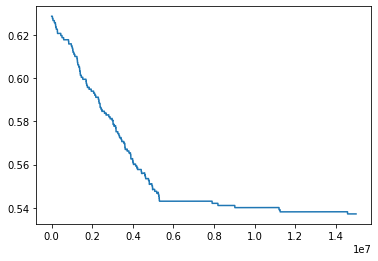

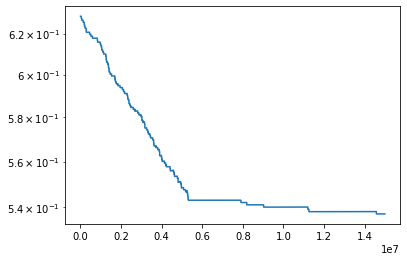

In [17]:
print("Max error: ", np.max(np.abs(Qtd-Qpi_sequence[-1])))
print("Max error: ", np.max(np.abs(Qtd-Qopt_sequence[-1])))
plt.figure()
plt.plot(error)
plt.figure()
plt.semilogy(error)

#Q-learning
For a sample $(s,a,r,s')$, the temporal difference is:

$\delta = r + \gamma \max_{a'} Q(s',a') - Q(s,a)$

And the TD update is:

$Q(s,a) \leftarrow Q(s,a) + \alpha \left[ r + \gamma \max_{a'} Q(s',a') - Q(s,a) \right]$

As long as all state-action pairs $(s,a)$ are sampled infinitely often as $t \rightarrow \infty$, and under the Robbins-Monro conditions, this procedure converges to $Q^*$.

$Q$ converges to $Q^*$ even if the behavior policy does not.

In [18]:
from copy import deepcopy

def qlearning(env, Qinit, alpha=0.01, gamma=0.9, epsilon=1, max_iterations=5000000):
  error = np.zeros((max_iterations))
  count = np.zeros((env.observation_space.n, env.action_space.n))
  Q = deepcopy(Qinit)

  x, _, _, _ = env.step(np.random.randint(env.action_space.n))
  for i in tqdm(range(max_iterations)):
    # Modify epsilon
    if (i+1)%1000000 == 0:
      epsilon = epsilon / 2
    # Explore / Exploit
    a = np.argmax(Q[x, :])
    if np.random.rand() < epsilon:
      a = np.random.randint(env.action_space.n)
    # Evaluate
    y, r, d, _ = env.step(a)
    Q[x, a] = Q[x, a] + alpha * (r + gamma*np.max(Q[y, :]) - Q[x, a])

    count[x, a] += 1

    if d == True:
      x = env.reset()
    else:
      x = y
  
  return Q, count

In [19]:
Q, count = qlearning(env, Qinit=Qpi_sequence[-1], max_iterations=15000000)

100%|██████████| 15000000/15000000 [11:13<00:00, 22274.05it/s]


Max error:  0.052699529955104574


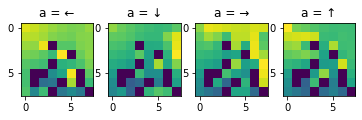

  (Right)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG


In [20]:
print("Max error: ", np.max(np.abs(Q-Qopt_sequence[-1])))

count_map = np.zeros((env.unwrapped.nrow, env.unwrapped.ncol, env.action_space.n))
for a in range(env.action_space.n):
  for x in range(env.observation_space.n):
    col = x%env.unwrapped.ncol
    row = int((x-col)/env.unwrapped.ncol)
    count_map[row, col, a] = count[x,a]

fig, axs = plt.subplots(ncols=4)
for a in range(env.action_space.n):
  name = "a = " + actions[a]
  axs[a].set_title(name)
  axs[a].imshow(np.log(count_map[:,:,a]+1), interpolation='nearest')

plt.show()
env.render()

In [21]:
def epsilon_greedy_policy(Q):
  pi = np.zeros((env.observation_space.n), np.int)
  for s in range(env.observation_space.n):
    pi[s] = np.argmax(Q[s, :])
  return pi

def plot_policy(env, policy):
  for row in range(env.unwrapped.nrow):
    for col in range(env.unwrapped.ncol):
      print(actions[pi[row*env.unwrapped.ncol+col]], end='')
    print('')

In [22]:
pi = epsilon_greedy_policy(Q)

plot_policy(env, pi)

↑→→→→→→→
↑↑↑↑→→→↓
↑↑←←→↑→↓
↑↑↑↓←←→↓
↑↑←←→↓↑→
←←←→↑←←→
←←→↑←←←→
←↓←←↓↓↓←


# Let's play with Mountain Car

Observation space is now continuous

In [23]:
env = wrap_env(gym.make('MountainCar-v0'))
env.seed(16)

print('Action space for Mountain car env: '+str(env.action_space))
print('Observation space for Mountain car env: '+str(env.observation_space))

Action space for Mountain car env: Discrete(3)
Observation space for Mountain car env: Box(-1.2000000476837158, 0.6000000238418579, (2,), float32)


In [24]:
import numpy as np

# Let's define some buckets for the states

n_states = 36

def get_state_values(env, obs):
  env_low = env.observation_space.low
  env_high = env.observation_space.high

  env_delta = (env_high - env_low) / n_states
  pos = int((obs[0] - env_low[0])/env_delta[0])
  vel = int((obs[1] - env_low[1])/env_delta[1])

  return pos, vel

q_table = np.zeros((n_states, n_states, 3))

In [25]:
actions = {0: '\u2190', 1: '\u2504', 2: '\u2192'}

In [26]:
# learning rate
min_lr = 0.003
initial_lr = 1
# discount factor
gamma = 0.9
# exploration factor
eps = 0.02
# max number of episodes
ep_max = 1000
# max number of iterations
iter_max = 1000

In [27]:
# Q-Learning

for i in tqdm(range(ep_max)):
  obs = env.reset()
  eta = max(min_lr, initial_lr*(0.85**(i//100)))
  for j in range(iter_max):
    pos, vel = get_state_values(env, obs)
    # Explore 2% 
    if np.random.uniform(0, 1) < eps:
      action = np.random.choice(env.action_space.n)
    # Exploit remaining time
    else:
      logits = q_table[pos][vel]
      logits_exp = np.exp(logits)
      probs = logits_exp / np.sum(logits_exp)
      action = np.random.choice(env.action_space.n, p=probs)

    obs, reward, done, _ = env.step(action)

    pos_, vel_ = get_state_values(env, obs)
    q_table[pos][vel][action] = q_table[pos][vel][action] +\
      eta * (reward+gamma*np.max(q_table[pos_][vel_])-q_table[pos][vel][action])
    if done:
      break

100%|██████████| 1000/1000 [01:09<00:00, 14.41it/s]


In [28]:
pi = np.argmax(q_table, axis=2)

for vel in range(n_states):
    for pos in range(n_states):
      print(actions[pi[pos, vel]], end='')
    print('')

←←←←←←←←←←←←←←←←←←←←←←←←←←←←←←←←←←←←
←←←←←←←←←←←←←←←←←←←←←←←←←←←←←←←←←←←←
←←←←←←←←←←←←←←←←←←←←←←←←←←←←←←←←←←←←
←←←←←←←←←←←←←←←←←←←←←←←←←←←←←←←←←←←←
←←←←←←←←←←←←←←←←←←←←←←←←←←←←←←←←←←←←
←←←←←←←←←←←←←←←←←←←←←←←←←←←←←←←←←←←←
←←←←←←←←←←←←←←←←←←←←←←←←←←←←←←←←←←←←
←←←←←←←←←┄→→→┄→←←←←←←←←←←←←←←←←←←←←←
←←←←←←←┄←┄←←←┄→→←┄┄←←←←←←←←←←←←←←←←←
←←←←←←←→←←←←┄←←┄←←┄→←←←←←←←←←←←←←←←←
←←←←←←→┄←←┄←←←←←←←┄←←←←←←←←←←←←←←←←←
←←←←←←┄←←┄←←←┄←←←←←←┄←←←←←←←←←←←←←←←
←←←←┄┄┄←┄←←←←←←┄←←┄┄→┄←←←←←←←←←←←←←←
←←←←┄←←←←←←←←←←←←┄←←→→┄←←←←←←←←←←←←←
←←←←┄←←←←←←←←←┄←←┄→┄┄→┄←←←←←←←←←←←←←
←←←┄←┄←┄←┄←┄←←←←←┄┄┄┄┄←←←←←←←←←←←←←←
←←→┄←┄←←→←→┄→←←┄←┄←→←→→┄←←←←←←←←←←←←
←←←→←←┄┄←┄→→→←┄┄←←←←┄→┄←←←←←←←←←←←←←
←←→←┄┄┄→→→→→┄┄←←┄←←→┄→→→←←←←←←←←←←←←
←←←┄┄┄┄→┄┄→→→→→→→→┄┄←→→┄←←←←←←←←←←←←
←←←←←←←┄→→→→→→→→┄┄←←→┄┄→←←←←←←←←←←←←
←←←←┄→→→→→→┄→┄→┄→←┄┄┄┄←←←←←←←←←←←←←←
←←←←←→→┄┄←→→→→→→→┄→┄┄←←←←←←←←←←←←←←←
←←←←←←→→→┄→┄→→┄→→→→→←→←←←←←←←←←←←←←←
←←←←←→←┄→→→→→→→→→→→→┄┄←←←←←←←←←←←←←←
←←←←←←←┄→→┄→→→→→→┄┄→┄←←←←←←←←←←←←←←←
←←←←←←←←←←┄←┄←→→→→┄┄←←←←←←←←←←←←←←←←
←

In [29]:
def run_episode(env, policy=None, render=False):
  total_reward = 0
  obs = env.reset()
  for step in range(iter_max):
    if render:
      env.render()
    action = None
    if policy is None:
      action = np.random.choice(env.action_space.n)
    else:
      pos, vel = get_state_values(env, obs)
      action = policy[pos, vel]
    obs, reward, done, _ = env.step(action)
    total_reward += reward*gamma**step
    if done:
      break
  return total_reward        

In [30]:
rewards = []
rewards = [run_episode(env, policy=pi, render=True) for _ in range(100)]

show_video()

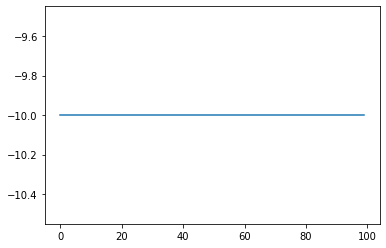

In [31]:
plt.figure()
plt.plot(rewards)

In [32]:
!zip -r /content/file.zip /content/video/

from google.colab import files
files.download("/content/file.zip")

  adding: content/video/ (stored 0%)
  adding: content/video/openaigym.video.1.11586.video000064.meta.json (deflated 60%)
  adding: content/video/openaigym.video.1.11586.video001000.mp4 (deflated 7%)
  adding: content/video/openaigym.video.1.11586.video000343.mp4 (deflated 10%)
  adding: content/video/openaigym.video.1.11586.video001000.meta.json (deflated 60%)
  adding: content/video/openaigym.video.1.11586.video000027.mp4 (deflated 11%)
  adding: content/video/openaigym.video.1.11586.video000027.meta.json (deflated 60%)
  adding: content/video/openaigym.video.1.11586.video000000.mp4 (deflated 11%)
  adding: content/video/openaigym.video.1.11586.video000008.meta.json (deflated 60%)
  adding: content/video/openaigym.video.1.11586.video000125.meta.json (deflated 60%)
  adding: content/video/openaigym.video.1.11586.video000343.meta.json (deflated 60%)
  adding: content/video/openaigym.video.1.11586.video000001.meta.json (deflated 60%)
  adding: content/video/openaigym.video.1.11586.video

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>